In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import  datetime
import time
%matplotlib inline

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 

There are 50000 training images and 10000 test images.

CIFAR-10 Dataset [CIFAR10-Toronto](https://www.cs.toronto.edu/~kriz/cifar.html)

In [2]:
from CIFAR10_load import read_files
((Training_Images,Training_Labels),(Test_Images,Test_Labels),CIFAR10_LABELS) = read_files()

-------------------------------------------------
Extraction of CIFAR10 Dataset Done
Shape of Training Images : (50000, 32, 32, 3)
Shape of Training Labels : (50000,)
Shape of Test Images     : (10000, 32, 32, 3)
Shape of Test Labels     : (10000,)
-------------------------------------------------


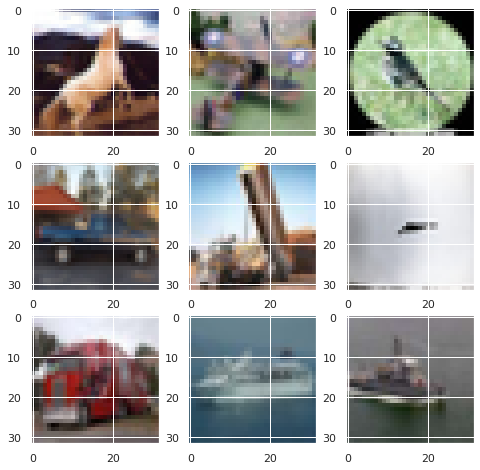

In [3]:
fig, ax = plt.subplots(3, 3,figsize=(8,8))

for i in range(3):
    for j in range(3):
        k = np.random.randint(0,50000)
        ax[i][j].imshow(Training_Images[k])

plt.show()

#### Build CNN Models using Transfer Learning

In [4]:
# Hyperparameter Initialization 
Epoch_Number = 20 
Batch_Size = 64

#### Lets First use VGG16 
[VGG16 Doc](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

In [5]:
BUILD_MODEL = "VGG16"

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,BatchNormalization,Flatten,Dropout
from tensorflow.keras.models import Sequential

In [6]:
# Preprocessing images to be suitable for VGG16 
from sklearn.model_selection import train_test_split

# Training_Images = tf.image.resize(Training_Images, (96, 96))
# Test_Images = tf.image.resize(Test_Images, (96, 96))

X_train,X_val,y_train,y_val = train_test_split(Training_Images,Training_Labels,test_size=0.1)

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
Test_Images = preprocess_input(Test_Images)

In [7]:
# Creating Base Model
base_model = VGG16(weights='imagenet', include_top=False,input_shape=X_train[0].shape)

# Setting Base Model Layers to Non-Trainable
for layers in base_model.layers:
    layers.trainable=False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [8]:
CIFAR10_Model = Sequential()

CIFAR10_Model.add(base_model)

CIFAR10_Model.add(Flatten())

CIFAR10_Model.add(Dense(256,activation="relu",kernel_regularizer='l2'))
CIFAR10_Model.add(Dropout(0.2))
CIFAR10_Model.add(BatchNormalization())

CIFAR10_Model.add(Dense(128,activation="relu",kernel_regularizer='l2'))
CIFAR10_Model.add(Dropout(0.2))
CIFAR10_Model.add(BatchNormalization())

CIFAR10_Model.add(Dense(64,activation="tanh",kernel_regularizer='l2'))
CIFAR10_Model.add(Dropout(0.2))

CIFAR10_Model.add(Dense(10,activation="softmax"))

In [9]:
CIFAR10_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [10]:
Model_Name = f"CIFAR10-Transfer_{BUILD_MODEL}_{time.time()}"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{Model_Name}")

# Implementing Early Stopping 
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)



CIFAR10_Model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])

CIFAR10_Model.fit(
                    X_train, y_train, 
                    epochs = Epoch_Number, 
                    batch_size = Batch_Size,
                    validation_data = (X_val,y_val),                
                    callbacks=[tensorboard_callback,earlystopping_callback], 
                )

Epoch 1/20
704/704 [==============================] - 53s 17ms/step - loss: 6.8665 - accuracy: 0.1295 - val_loss: 3.9408 - val_accuracy: 0.2332
Epoch 2/20
704/704 [==============================] - 9s 13ms/step - loss: 3.8429 - accuracy: 0.2002 - val_loss: 3.2508 - val_accuracy: 0.2482
Epoch 3/20
704/704 [==============================] - 9s 13ms/step - loss: 3.2485 - accuracy: 0.2268 - val_loss: 2.9260 - val_accuracy: 0.2740
Epoch 4/20
704/704 [==============================] - 9s 13ms/step - loss: 2.9233 - accuracy: 0.2424 - val_loss: 2.7760 - val_accuracy: 0.2550
Epoch 5/20
704/704 [==============================] - 9s 13ms/step - loss: 2.6794 - accuracy: 0.2587 - val_loss: 2.4535 - val_accuracy: 0.3038
Epoch 6/20
704/704 [==============================] - 9s 13ms/step - loss: 2.4787 - accuracy: 0.2708 - val_loss: 2.3295 - val_accuracy: 0.2902
Epoch 7/20
704/704 [==============================] - 9s 13ms/step - loss: 2.3395 - accuracy: 0.2758 - val_loss: 2.2690 - val_accuracy: 0.269